Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [15]:
from random import random, seed
from itertools import accumulate
from icecream import ic
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [16]:
UNIVERSE_SIZE = 1_000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [17]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [18]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [19]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(33610.76162917397))

In [20]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(15564.725543238317))

UTILS

In [21]:
def print_fitness_history(history: list, history_valid_sol: list):
    mask = np.array(history_valid_sol) > -float('inf')
    x = np.arange(len(history_valid_sol))[mask]
    y = np.array(history_valid_sol)[mask]
    plt.figure(figsize=(14,8))
    plt.scatter(range(len(history)), history, marker=".")
    plt.plot(
    x,
    list(accumulate(y, max)),
    color = "red"
    )

FITNESS

In [22]:
def fitness_by_validity(solution: np.ndarray) -> tuple[bool, float]:
    return (int(valid(solution)), float(-cost(solution)))

def fitness_by_setNumber(solution: np.ndarray) -> tuple[int, float]:
    taken_items = int(np.sum(np.any(SETS[solution,:], axis=0)))
    return (taken_items, float(-cost(solution)))

MUTATION FUNCTIONS

In [23]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    temp = solution.copy()
    idx = rng.integers(NUM_SETS)
    temp[idx] = not temp[idx]
    return temp

def single_mutation_iterative(solution: np.ndarray) -> np.ndarray:
    temp = solution.copy()
    idx = None
    while idx is None or np.random.random() < 0.5:
        idx = rng.integers(NUM_SETS)
        temp[idx] = not temp[idx]
    return temp

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01
    temp = np.logical_xor(solution, mask)
    return temp

<h3>RANDOM MUTATION HILL CLIMBER</h3>

ic| fitness: (0, -0.0)


ic| fitness: (1000, -7342.633380851675)


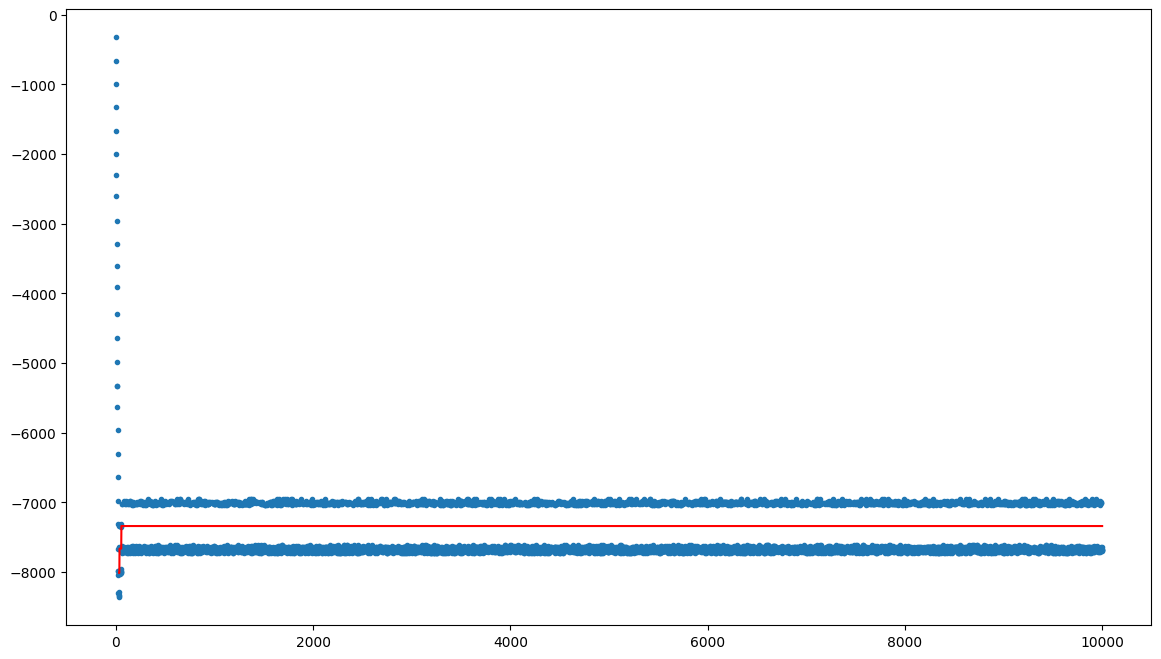

In [24]:
solution = np.full(NUM_SETS, False)

fitness_function = fitness_by_setNumber
tweak = single_mutation

fitness = fitness_function(solution)

history = list()
history_valid_sol = [-float('inf')]

ic(fitness)

for steps in range(10_000):
    new_sol = tweak(solution)
    new_fitness = fitness_function(new_sol)
    history.append(new_fitness[1])
    
    if new_fitness[0] == UNIVERSE_SIZE:
        history_valid_sol.append(new_fitness[1])
    else:
        history_valid_sol.append(history_valid_sol[-1])

    if new_fitness > fitness:
        solution = new_sol
        fitness = new_fitness

ic(fitness)
print_fitness_history(history, history_valid_sol)

<h3>STEEPEST STEP HILL CLIMBER</h3>

ic| fitness: (0, -0.0)


ic| fitness: (1000, -6750.183911425183)


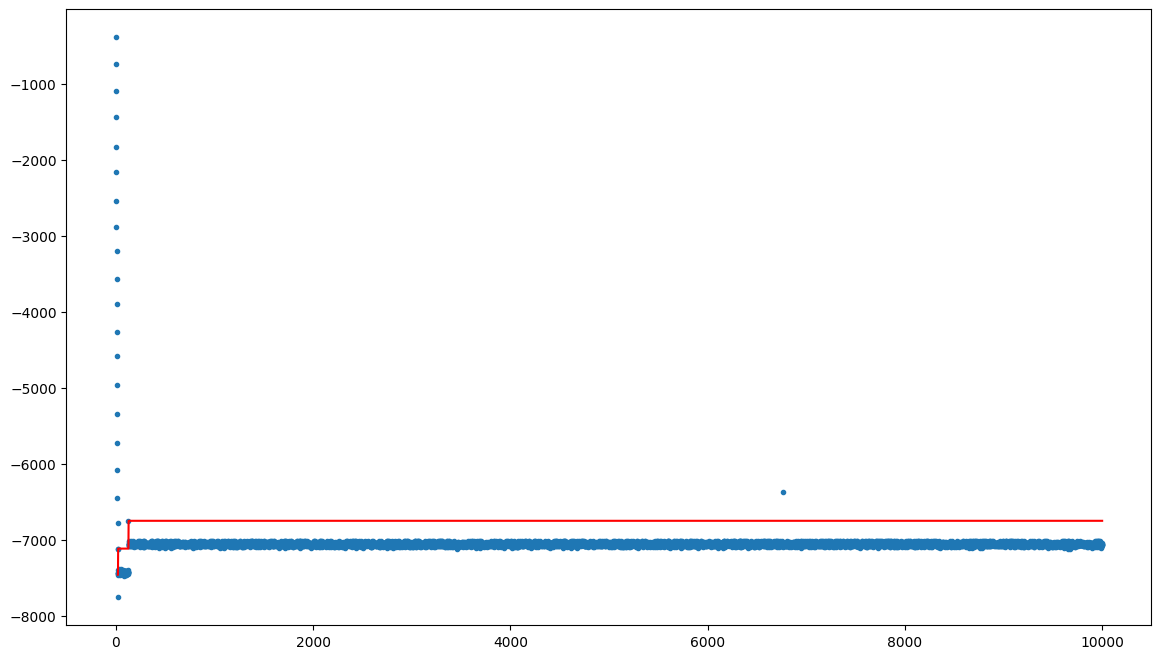

In [25]:
NUM_CANDIDATES = 5

solution = np.full(NUM_SETS, False)

fitness_function = fitness_by_setNumber
tweak = single_mutation

fitness = fitness_function(solution)

history = list()
history_valid_sol = [-float('inf')]

ic(fitness)

for steps in range(10_000):
    candidates = [tweak(solution) for _ in range(NUM_CANDIDATES)]
    candidates_fitness = [fitness_function(c) for c in candidates]

    index = candidates_fitness.index(max(candidates_fitness))

    new_sol = candidates[index]
    new_fitness = candidates_fitness[index]
    history.append(new_fitness[1])

    if new_fitness[0] == UNIVERSE_SIZE:
        history_valid_sol.append(new_fitness[1])
    else:
        history_valid_sol.append(history_valid_sol[-1])

    if new_fitness > fitness:
        solution = new_sol
        fitness = new_fitness

ic(fitness)
print_fitness_history(history, history_valid_sol)

<h3>STEEPEST STEP HILL CLIMBER WITH RESTART<h3>

ic| max_fitness: (1000, -6160.523246369503)


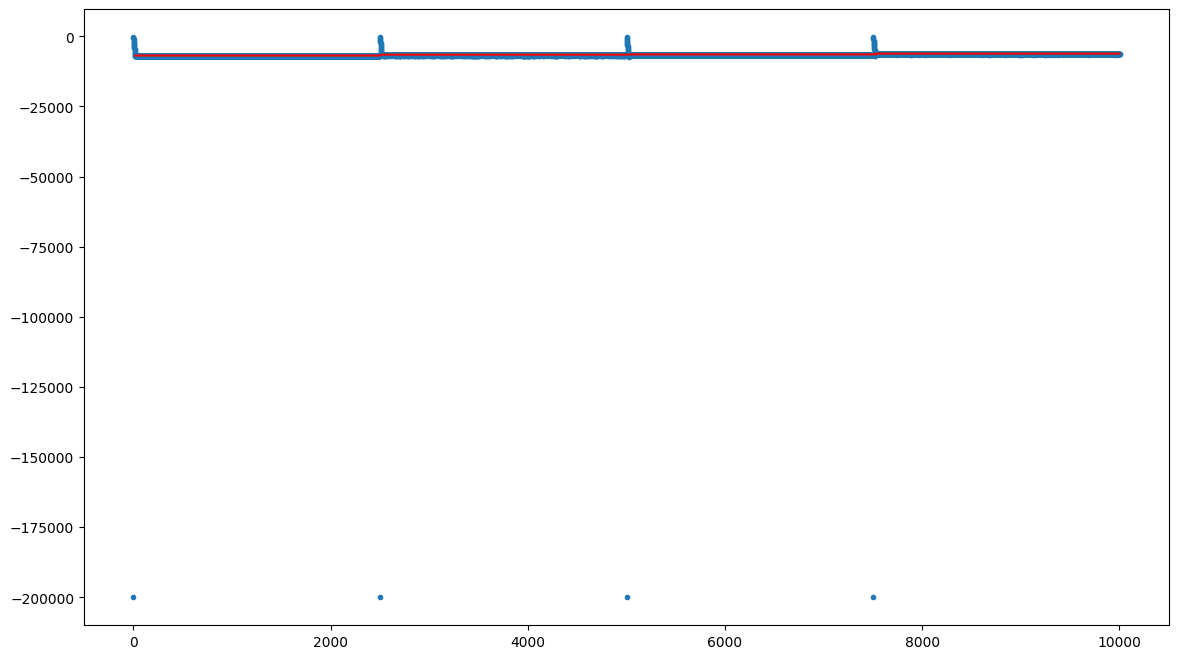

In [26]:
NUM_CANDIDATES = 10
NUM_RESTARTS = 4

fitness_function = fitness_by_setNumber
max_fitness = (0, -float('inf'))
tweak = single_mutation

history = list()
history_valid_sol = list()

for _ in range(NUM_RESTARTS):
    solution = np.full(NUM_SETS, False)
    fitness = fitness_function(solution)
    history.append(float(-200_000))
    history_valid_sol.append(-float('inf'))

    for steps in range(10_000 // NUM_RESTARTS):
        candidates = [tweak(solution) for _ in range(NUM_CANDIDATES)]
        candidates_fitness = [fitness_function(c) for c in candidates]

        index = candidates_fitness.index(max(candidates_fitness))

        new_sol = candidates[index]
        new_fitness = candidates_fitness[index]
        history.append(new_fitness[1])

        if new_fitness[0] == UNIVERSE_SIZE:
            history_valid_sol.append(new_fitness[1])
        else:
            history_valid_sol.append(history_valid_sol[-1])

        if new_fitness > fitness:
            solution = new_sol
            fitness = new_fitness
    
    if fitness > max_fitness:
        max_fitness = fitness
        best_solution = solution

ic(max_fitness)
print_fitness_history(history, history_valid_sol)